# Tutorial 3: Mouse Brain dataset

In this tutorial, we demonstrate how to use S3RL to analyze the Mouse Brain Anterior dataset from 10X Genomics. This dataset captures anterior brain structures and is commonly used for evaluating spatial clustering performance.

The dataset can be downloaded from the 10X Genomics resource portal (https://mouse.brain-map.org/static/atlas), including spatial gene expression matrices and histology images.

We applied S3RL on the H&E image, gene expression, and spatial coordinates to identify anatomical domains. The model successfully highlights biologically distinct regions such as the glomerular and mitral layers, supported by spatial marker genes like Gabra1 and Penk.

#### Prepare data

In [ ]:
from Utility.tools import  load_train_data
import os

dataset = 'Mouse_Brain_Anterior'
id = ''
pixel_size = 10
img_path = os.path.join('./Img_encoder/models/', dataset, id, 'img_emb.npy')
data_path = './Data'
knn = 5

edge_index, fea, G, G_neg, gt, adata = load_train_data(id=id, 
                                                       knn=knn, 
                                                       data_path=os.path.join(data_path, dataset), 
                                                       img_path=img_path, 
                                                       margin=pixel_size, 
                                                       dataset=dataset, 
                                                       return_adata=True)

#### Train model

In [2]:
from Utility.train_w_data import train_
import yaml

cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, dataset+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

ari, label_pred, emb, recon = train_(edge_index, fea, G, G_neg, gt, cfg)

print(f'The final ARI is {ari}')

Training:  88%|████████▊ | 4400/5000 [03:51<00:31, 18.99it/s]

Reached the tolerance, early stop training at epoch 4400
The final ARI is 0.5096722891630927


#### Visualization

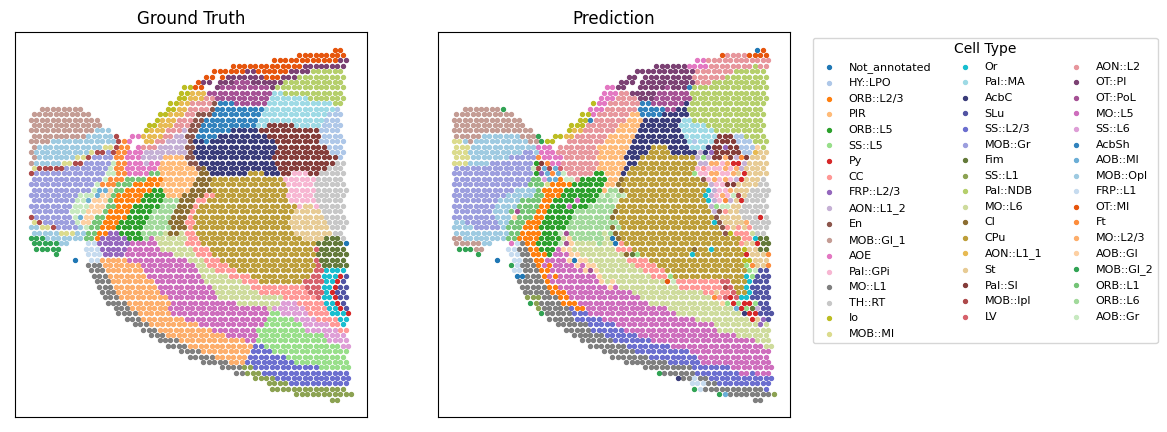

In [5]:
import matplotlib
from Utility.tools import hungarian_match
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

label_pred = hungarian_match(gt, label_pred)
label_dict = dict(zip(adata.obsm['label_dict'].values, adata.obs['Ground Truth'].values))

colors = np.vstack([np.array(matplotlib.colormaps['tab20'].colors), 
                    np.array(matplotlib.colormaps['tab20b'].colors), 
                    np.array(matplotlib.colormaps['tab20c'].colors)])

for j, label in enumerate(np.unique(gt)):
    axs[0].scatter(adata.obsm['spatial'][gt==label, 0], adata.obsm['spatial'][gt==label, 1], color=colors[j], s=8)
    axs[1].scatter(adata.obsm['spatial'][label_pred==label, 0], adata.obsm['spatial'][label_pred==label, 1], color=colors[j], s=8, label=label_dict[label])

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title='Cell Type', title_fontsize=10, ncol=3)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[0].set_title('Ground Truth')
axs[1].set_title('Prediction')

plt.show()